In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
workspace_path = '/gdrive/My Drive/Colab Notebooks'

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
import random
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
seed = 719 # seed를 따로 설정을 하지 않으면 random number가 부여가 되므로 설정을 해야한다.
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=True

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3,
                      stride=1, padding=1, bias=False),  # 1x28x28 -> 10x28x28
            nn.BatchNorm2d(10),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3,
                      stride=1, padding=1, bias=False),  # 10x28x28 -> 20x28x28, bias =  False로 잡는 이유 : batchNormalizaion에 포함되어있으므로
            nn.BatchNorm2d(20),
            nn.ReLU(inplace=True), # 값 자체를 메모리 공간에서 연산수행
            nn.MaxPool2d(kernel_size=2),  # 20x28x28 -> 20x14x14 (2배로 특징 압축)
            nn.Conv2d(in_channels=20, out_channels=40, kernel_size=3, # 채널 수 총 40
                      stride=1, padding=1, bias=False),  # 20x14x14 -> 40x14x14
            nn.BatchNorm2d(40),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # 40x14x14 -> 40x7x7 (이미지 축소 후 특징 압축)
            nn.Conv2d(in_channels=40, out_channels=80, kernel_size=3, # 채널 총 80
                      stride=1, padding=1, bias=False),  # 40x7x7 -> 80x7x7
            nn.BatchNorm2d(80),
            nn.AdaptiveAvgPool2d(1)  # 2d디멘션 값을 평균값으로, 80x7x7 -> 80x1x1 (채널 별 평균값 계산), 하나의 값으로 pooling
        )
        self.fc = nn.Linear(80, 10)  # MNIST 10종 판별

    def forward(self, x):
        x = x.float()
        x = x.view(-1, 1, 28, 28)  # view 함수로 형태를 reshape (채널이 1이고 28x28 이미지고, -1 = 배치개수만큼 반영을 해준다) [batch크기, 1, 28,28]
        x = self.main(x)
        x = x.view(-1, 80)  # [batch크기, 80]
        x = self.fc(x)
        return x

print("init model done")

init model done


In [ ]:
batch_size = 64
test_batch_size = 1000
max_epochs = 10
lr = 0.01
momentum = 0.5
log_interval = 200
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers':1, 'pin_memory':True} if use_cuda else {}
print("set vars and device done")

set vars and device done


In [ ]:
transform = transforms.Compose([
                                transforms.ToTensor(), # numpy --> tensor로 변환
                                transforms.Normalize((0.5,), (0.5,)) # 일반적으로 (학습데이터셋 평균, 표준편차)
])

#학습용 데이터 가져오기
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(os.path.join(workspace_path, 'data'), train=True, download=True, transform=transform),
    batch_size = batch_size, shuffle=True, drop_last = True, **kwargs)

#테스트용 데이터 가져오기
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(os.path.join(workspace_path, 'data'), train=False, download=True, transform=transform), # drop_last의 default값이 false이므로 정의 하지 않음.
    batch_size=test_batch_size, shuffle = False, **kwargs
)

<Figure size 432x288 with 0 Axes>

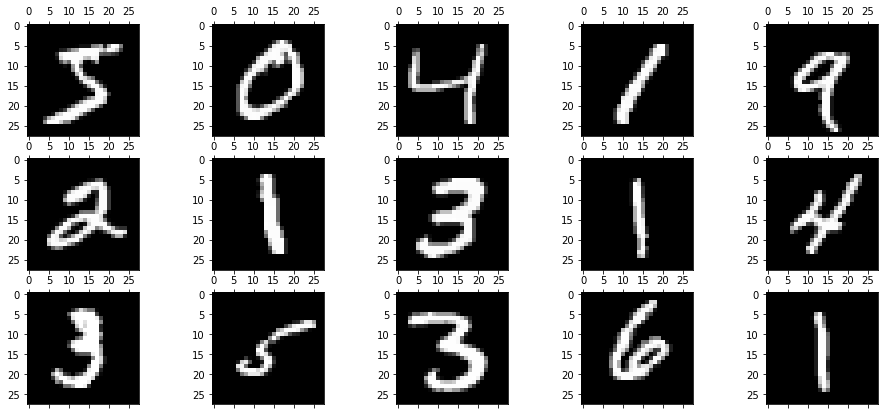

In [ ]:
plt.gray()
fig = plt.figure( figsize=(16,7) )
for i in range(0,15):
    data, _ = train_loader.dataset[i]
    data = data.numpy()
    ax = fig.add_subplot(3,5,i+1, title="")
    ax.matshow(data.reshape((28,28)).astype(float))
plt.show()

In [ ]:
model = Net().to(device) # 모델정의
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum) # 최적화 알고리즘 정의
criterion = nn.CrossEntropyLoss()

In [ ]:
class AverageMeter(object): # 수치값 저장에 용이하도록 클래스 지정
  """Computes and stores the average and current value"""
  def __init__(self):
        self.reset()

  def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

  def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def train(log_interval, model, device, train_loader, optimizer, epoch):
    model.train()
    summary_loss = AverageMeter()
    summary_acc = AverageMeter()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        summary_loss.update(loss.detach().item())
        pred = output.argmax(dim=1, keepdim=True)
        correct = pred.eq(target.view_as(pred)).sum().item()
        summary_acc.update(correct / data.size(0))
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tAverage loss: {:.6f}, Accuracy: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), summary_loss.avg, summary_acc.avg))
            
    return summary_loss.avg, summary_acc.avg

def test(log_interval, model, device, test_loader):
    model.eval()
    summary_loss = AverageMeter()
    summary_acc = AverageMeter()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            summary_loss.update(loss.detach().item())
            pred = output.argmax(dim=1, keepdim=True)
            correct = pred.eq(target.view_as(pred)).sum().item()
            summary_acc.update(correct / data.size(0))

    print('\nTest set: Average loss: {:.4f}, Accuracy: {:.6f}\n'.format
          (summary_loss.avg, summary_acc.avg))

    return summary_loss.avg, summary_acc.avg

In [ ]:
for epoch in range(1, max_epochs+1):
    best_acc = 0
    best_epoch = 0
    train_loss, train_acc = train(log_interval, model, device, train_loader, optimizer, epoch)
    test_loss, test_acc = test(log_interval, model, device, test_loader)

   
    if test_acc > best_acc:
        best_acc = test_acc
        best_epoch = epoch
        torch.save(model, os.path.join(workspace_path, f'mnist_cnn_model_best_acc_{best_epoch}-epoch.pt'))
        print(f'# save model: mnist_cnn_model_best_acc_{best_epoch}-epoch.pt\n')

print(f'\n\n# Best accuracy model({best_acc * 100:.2f}%): mnist_cnn_model_best_acc_{best_epoch}-epoch.pt\n')

Train Epoch: 1 [0/60000 (0%)]	Average loss: 2.340623, Accuracy: 0.000000
Train Epoch: 1 [12800/60000 (21%)]	Average loss: 1.756628, Accuracy: 0.407649
Train Epoch: 1 [25600/60000 (43%)]	Average loss: 1.408700, Accuracy: 0.559305
Train Epoch: 1 [38400/60000 (64%)]	Average loss: 1.132640, Accuracy: 0.667195
Train Epoch: 1 [51200/60000 (85%)]	Average loss: 0.942565, Accuracy: 0.731605

Test set: Average loss: 0.3589, Accuracy: 0.894600

# save model: mnist_cnn_model_best_acc_1-epoch.pt

Train Epoch: 2 [0/60000 (0%)]	Average loss: 0.363089, Accuracy: 0.890625
Train Epoch: 2 [12800/60000 (21%)]	Average loss: 0.244934, Accuracy: 0.945118
Train Epoch: 2 [25600/60000 (43%)]	Average loss: 0.229199, Accuracy: 0.946852
Train Epoch: 2 [38400/60000 (64%)]	Average loss: 0.213536, Accuracy: 0.949615
Train Epoch: 2 [51200/60000 (85%)]	Average loss: 0.200313, Accuracy: 0.952618

Test set: Average loss: 0.1988, Accuracy: 0.944500

# save model: mnist_cnn_model_best_acc_2-epoch.pt

Train Epoch: 3 [0/6000

# **CIFAR10**

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
workspace_path = '/gdrive/My Drive/Colab Notebooks'

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
import random
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
seed = 719
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark=True

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.main = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=10,kernel_size=3,stride=1, padding=1, bias=False), nn.BatchNorm2d(10), nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3,stride=1, padding=1, bias=False), nn.BatchNorm2d(20), nn.ReLU(inplace=True), nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=20, out_channels=40, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(40), nn.ReLU(inplace=True), nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=40, out_channels=80, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(80), nn.AdaptiveAvgPool2d(1)
    )
    self.fc = nn.Linear(80,10)
  
  def forward(self, x):
        x = x.float()
        x = x.view(-1, 3, 32, 32) 
        x = self.main(x) 
        x = x.view(-1, 80) 
        x = self.fc(x)
        return x

print("init model done")

init model done


In [ ]:
batch_size = 64  # 학습 배치 크기
test_batch_size = 1000  # 테스트 배치 크기 (학습 과정을 제외하므로 더 큰 배치 사용 가능)
max_epochs = 10  # 학습 데이터셋 총 훈련 횟수
lr = 0.01  # 학습률
momentum = 0.5  # SGD에 사용할 모멘텀 설정 (파라미터 업데이트 시 관성 효과 사용)
log_interval = 200  # interval 때마다 로그 남김

use_cuda = torch.cuda.is_available()  # GPU cuda 사용 여부 확인

device = torch.device("cuda" if use_cuda else "cpu")  # GPU cuda 사용하거나 없다면 CPU 사용

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}  # num_workers: data loading할 프로세스 수, pin_memory: 고정된 메모리 영역 사용

print("set vars and device done")

set vars and device done


In [ ]:
transform = transforms.Compose([
                 transforms.ToTensor(),
                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_loader = torch.utils.data.DataLoader(
  datasets.CIFAR10(os.path.join(workspace_path, 'data'), train=True, download=True, 
                   transform=transform), 
    batch_size = batch_size, shuffle=True, drop_last=True, **kwargs)


test_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(os.path.join(workspace_path, 'data'), train=False, download=True,
                         transform=transform), 
    batch_size=test_batch_size, shuffle=False, **kwargs)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
criterion = nn.CrossEntropyLoss()

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def train(log_interval, model, device, train_loader, optimizer, epoch):
    model.train()
    summary_loss = AverageMeter()
    summary_acc = AverageMeter()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        summary_loss.update(loss.detach().item())
        pred = output.argmax(dim=1, keepdim=True)
        correct = pred.eq(target.view_as(pred)).sum().item()
        summary_acc.update(correct / data.size(0))
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tAverage loss: {:.6f}, Accuracy: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), summary_loss.avg, summary_acc.avg))
            
    return summary_loss.avg, summary_acc.avg

def test(log_interval, model, device, test_loader):
    model.eval()
    summary_loss = AverageMeter()
    summary_acc = AverageMeter()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            summary_loss.update(loss.detach().item())
            pred = output.argmax(dim=1, keepdim=True)
            correct = pred.eq(target.view_as(pred)).sum().item()
            summary_acc.update(correct / data.size(0))

    print('\nTest set: Average loss: {:.4f}, Accuracy: {:.6f}\n'.format
          (summary_loss.avg, summary_acc.avg))

    return summary_loss.avg, summary_acc.avg

In [ ]:
best_acc = 0
best_epoch = 0
for epoch in range(1, max_epochs+1):
    train_loss, train_acc = train(log_interval, model, device, train_loader, optimizer, epoch)
    test_loss, test_acc = test(log_interval, model, device, test_loader)

    # 테스트에서 best accuracy 달성하면 모델 저장
    if test_acc > best_acc:
        best_acc = test_acc
        best_epoch = epoch
        torch.save(model, os.path.join(workspace_path, f'cifar10_cnn_model_best_acc_{best_epoch}-epoch.pt'))
        print(f'# save model: cifar10_cnn_model_best_acc_{best_epoch}-epoch.pt\n')

print(f'\n\n# Best accuracy model({best_acc * 100:.2f}%): cifar10_cnn_model_best_acc_{best_epoch}-epoch.pt\n')

Train Epoch: 1 [0/50000 (0%)]	Average loss: 2.320818, Accuracy: 0.109375
Train Epoch: 1 [12800/50000 (26%)]	Average loss: 1.856365, Accuracy: 0.311334
Train Epoch: 1 [25600/50000 (51%)]	Average loss: 1.742979, Accuracy: 0.357972
Train Epoch: 1 [38400/50000 (77%)]	Average loss: 1.678803, Accuracy: 0.386101

Test set: Average loss: 1.5780, Accuracy: 0.425600

# save model: cifar10_cnn_model_best_acc_1-epoch.pt

Train Epoch: 2 [0/50000 (0%)]	Average loss: 1.353207, Accuracy: 0.593750
Train Epoch: 2 [12800/50000 (26%)]	Average loss: 1.403444, Accuracy: 0.502643
Train Epoch: 2 [25600/50000 (51%)]	Average loss: 1.398757, Accuracy: 0.503741
Train Epoch: 2 [38400/50000 (77%)]	Average loss: 1.378675, Accuracy: 0.510685

Test set: Average loss: 1.2993, Accuracy: 0.526100

# save model: cifar10_cnn_model_best_acc_2-epoch.pt

Train Epoch: 3 [0/50000 (0%)]	Average loss: 1.166721, Accuracy: 0.625000
Train Epoch: 3 [12800/50000 (26%)]	Average loss: 1.293842, Accuracy: 0.539335
Train Epoch: 3 [25600/5

# **Baseline 보다 성능 높이기**

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.main = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=10,kernel_size=3,stride=1, padding=1, bias=False), nn.BatchNorm2d(10), nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3,stride=1, padding=1, bias=False), nn.BatchNorm2d(20), nn.ReLU(inplace=True), nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=20, out_channels=40, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(40), nn.ReLU(inplace=True), nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=40, out_channels=80, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(80), nn.AdaptiveAvgPool2d(1)
    )
    self.fc = nn.Linear(80,10)
  
  def forward(self, x):
        x = x.float()
        x = x.view(-1, 3, 32, 32) 
        x = self.main(x) 
        x = x.view(-1, 80) 
        x = self.fc(x)
        return x

print("init model done")

init model done


In [ ]:
batch_size = 128 # 64 -> 128로 변경  
test_batch_size = 1000  
max_epochs = 10 
lr = 0.09 # 0.01에서 0.09로 learning rate 설정
momentum = 0.5 
log_interval = 200 

use_cuda = torch.cuda.is_available() 

device = torch.device("cuda" if use_cuda else "cpu") 

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}  

print("set vars and device done")

set vars and device done


In [ ]:
transform = transforms.Compose([
                 transforms.ToTensor(),
                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_loader = torch.utils.data.DataLoader(
  datasets.CIFAR10(os.path.join(workspace_path, 'data'), train=True, download=True, 
                   transform=transform), 
    batch_size = batch_size, shuffle=True, drop_last=True, **kwargs)


test_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(os.path.join(workspace_path, 'data'), train=False, download=True,
                         transform=transform), 
    batch_size=test_batch_size, shuffle=False, **kwargs)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
criterion = nn.CrossEntropyLoss()

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def train(log_interval, model, device, train_loader, optimizer, epoch):
    model.train()
    summary_loss = AverageMeter()
    summary_acc = AverageMeter()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        summary_loss.update(loss.detach().item())
        pred = output.argmax(dim=1, keepdim=True)
        correct = pred.eq(target.view_as(pred)).sum().item()
        summary_acc.update(correct / data.size(0))
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tAverage loss: {:.6f}, Accuracy: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), summary_loss.avg, summary_acc.avg))
            
    return summary_loss.avg, summary_acc.avg

def test(log_interval, model, device, test_loader):
    model.eval()
    summary_loss = AverageMeter()
    summary_acc = AverageMeter()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            summary_loss.update(loss.detach().item())
            pred = output.argmax(dim=1, keepdim=True)
            correct = pred.eq(target.view_as(pred)).sum().item()
            summary_acc.update(correct / data.size(0))

    print('\nTest set: Average loss: {:.4f}, Accuracy: {:.6f}\n'.format
          (summary_loss.avg, summary_acc.avg))

    return summary_loss.avg, summary_acc.avg

In [ ]:
best_acc = 0
best_epoch = 0
for epoch in range(1, max_epochs+1):
    train_loss, train_acc = train(log_interval, model, device, train_loader, optimizer, epoch)
    test_loss, test_acc = test(log_interval, model, device, test_loader)

    # 테스트에서 best accuracy 달성하면 모델 저장
    if test_acc > best_acc:
        best_acc = test_acc
        best_epoch = epoch
        torch.save(model, os.path.join(workspace_path, f'cifar10_cnn_model_best_acc_{best_epoch}-epoch.pt'))
        print(f'# save model: cifar10_cnn_model_best_acc_{best_epoch}-epoch.pt\n')

print(f'\n\n# Best accuracy model({best_acc * 100:.2f}%): cifar10_cnn_model_best_acc_{best_epoch}-epoch.pt\n')

Train Epoch: 1 [0/50000 (0%)]	Average loss: 2.351274, Accuracy: 0.093750
Train Epoch: 1 [12800/50000 (26%)]	Average loss: 1.687675, Accuracy: 0.372046
Train Epoch: 1 [25600/50000 (51%)]	Average loss: 1.565144, Accuracy: 0.426979
Train Epoch: 1 [38400/50000 (77%)]	Average loss: 1.480074, Accuracy: 0.459703

Test set: Average loss: 1.5235, Accuracy: 0.472100

# save model: cifar10_cnn_model_best_acc_1-epoch.pt

Train Epoch: 2 [0/50000 (0%)]	Average loss: 1.228828, Accuracy: 0.609375
Train Epoch: 2 [12800/50000 (26%)]	Average loss: 1.184344, Accuracy: 0.578436
Train Epoch: 2 [25600/50000 (51%)]	Average loss: 1.171883, Accuracy: 0.583346
Train Epoch: 2 [38400/50000 (77%)]	Average loss: 1.158183, Accuracy: 0.587796

Test set: Average loss: 1.3975, Accuracy: 0.513700

# save model: cifar10_cnn_model_best_acc_2-epoch.pt

Train Epoch: 3 [0/50000 (0%)]	Average loss: 1.207724, Accuracy: 0.609375
Train Epoch: 3 [12800/50000 (26%)]	Average loss: 1.071397, Accuracy: 0.624456
Train Epoch: 3 [25600/5

**개선 모델 성능**


1. lr = 0.05 설정 시
    
    63.9% 로 증가

2. batch_size = 128, lr = 0.09 로 설정 시

    67.16% 로 증가

**개선 아이디어 설명**

learning rate를 처음부터 크게 설정하면 학습이 잘되지 않아 0.01 -> 0.05 -> 0.09로 올렸고
배치 사이즈를 키우면 SGD 값은 동일하지만 노이즈가 감소합니다.